# Universal differential equation for the SIR model

In this script, we investigate the case that only a subset of species can be observed, which occurs often in experimental studies.

In [1]:
# SciML Tools
using OrdinaryDiffEq, SciMLSensitivity, Optimization, OptimizationOptimisers, OptimizationOptimJL

# Standard Libraries
using LinearAlgebra, Statistics, Random, Distributions

# External Libraries
using ComponentArrays, Lux, Zygote, Plots, StableRNGs
gr()

# Set a random seed for reproducible behaviour
rng = StableRNG(33);

### Define the SIR dynamics and solve the ODE

In [2]:
function sir!(du, u, p, t)
    β, γ, N = p
    du[1] = -β*u[1]*u[2]/N
    du[2] = β*u[1]*u[2]/N - γ*u[2]
    du[3] = γ*u[2]
end

p_ODE = [0.6, 0.3, 1.0]
u0 = [0.999, 0.001, 0.0]
tspan = (0.0, 40.0);

In [3]:
prob = ODEProblem(sir!, u0, tspan, p_ODE)
sol = solve(prob, Tsit5(), abstol = 1e-12, reltol = 1e-12, saveat = 1.0);

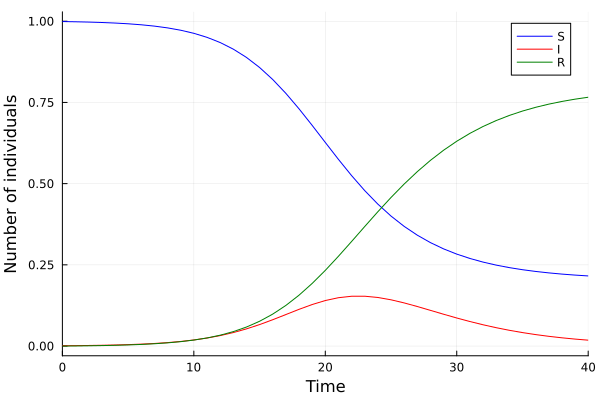

In [4]:
plot(sol, xlabel = "Time", ylabel = "Number of individuals", labels = ["S" "I" "R"], color = [:blue :red :green])

### Extract observable states and add multiplicative log-normal noise

In [5]:
t = sol.t
X = Array(sol)
dist = LogNormal(0, 0.1)
noise = rand(rng, dist, size(X[2:3, begin:4:end]))
X_noisy = noise .* X[2:3, begin:4:end];

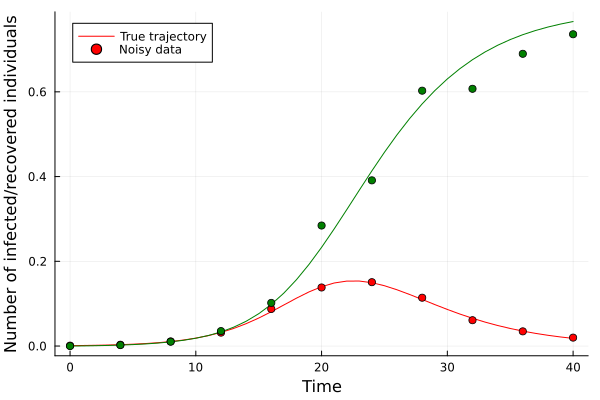

In [6]:
plot(t, X[2:3, :]', xlabel = "Time", ylabel = "Number of infected/recovered individuals", color = [:red :green], 
     label = ["True trajectory" nothing])
scatter!(t[begin:4:end], X_noisy', color = [:red :green], label = ["Noisy data" nothing])

### Set up the UDE

We set up our UDE by first defining the NN component and then the hybrid model $u'=f(u)+\text{NN}(u)$.

In [7]:
# Define activation function
rbf(x) = exp.(-(x .^ 2))   

# Multi-layer feed-forward neural network
model = Chain(Dense(3, 5, rbf), Dense(5, 5, rbf), Dense(5, 5, rbf), Dense(5, 3))

# Get initial parameters and state variables of the model
p_init, st = Lux.setup(rng, model);

In [8]:
# Define the hybrid model
β, γ, N = p_ODE

function ude_dynamics!(du, u, p, t)
    nn = Lux.apply(model, u, p, st)[1]   # Network prediction    
    du[1] = nn[1]
    du[2] = -γ*u[2] + nn[2] 
    du[3] = γ*u[2] + nn[3]
end

prob_ude = ODEProblem(ude_dynamics!, u0, tspan, p_init);

### Set up the training

In [9]:
function predict(p, saveat = t[begin:4:end])   # p is the parameter of the NN and the ODE at the same time
    _prob = remake(prob_ude, p = p)
    Array(solve(_prob, Tsit5(), abstol = 1e-6, reltol = 1e-6, saveat = saveat,
                sensealg = QuadratureAdjoint(autojacvec=ReverseDiffVJP(true))))
end;

In [10]:
function loss(p)
    X̂ = predict(p)
    mean(abs2, X_noisy .- X̂[2:3, :])   # MSE loss
end;

In [11]:
losses = Float64[]

function callback(p, l)
    push!(losses, l)
    n_iter = length(losses)
    if n_iter % 50 == 0   
        println("Loss after $(n_iter) iterations: $(losses[end])")
    end
    return false
end;

### Train the UDE

In [12]:
adtype = AutoZygote()   # automatic differentiation
optf = OptimizationFunction((p, _) -> loss(p), adtype)
optprob = OptimizationProblem(optf, ComponentVector{Float64}(p_init));

In [13]:
res1 = solve(optprob, ADAM(), callback = callback, maxiters = 5000);

Loss after 50 iterations: 108.21762435501445
Loss after 100 iterations: 6.717439760690653
Loss after 150 iterations: 2.2740163221899174
Loss after 200 iterations: 1.704067277221306
Loss after 250 iterations: 1.3637195682176702
Loss after 300 iterations: 1.1262161046558476
Loss after 350 iterations: 0.9439653613662938
Loss after 400 iterations: 0.7966512420811008
Loss after 450 iterations: 0.6740788587696989
Loss after 500 iterations: 0.5704439791975664
Loss after 550 iterations: 0.48209150159380326
Loss after 600 iterations: 0.406499177838206
Loss after 650 iterations: 0.3417833537447232
Loss after 700 iterations: 0.2864529944096528
Loss after 750 iterations: 0.23928458906239056
Loss after 800 iterations: 0.1992543215487486
Loss after 850 iterations: 0.1654960876114896
Loss after 900 iterations: 0.13726679702046599
Loss after 950 iterations: 0.1139128382502319
Loss after 1000 iterations: 0.09483237566112988
Loss after 1050 iterations: 0.07942767032562802
Loss after 1100 iterations: 0.0

In [14]:
optprob2 = OptimizationProblem(optf, res1.u)
res2 = solve(optprob2, LBFGS(), callback = callback, maxiters = 1500)
p_trained = res2.u;

Loss after 5050 iterations: 0.00032685641191935696
Loss after 5100 iterations: 0.00028494951306204044
Loss after 5150 iterations: 0.0002703647733419193
Loss after 5200 iterations: 0.0002593254717557158
Loss after 5250 iterations: 0.0002520928090947757
Loss after 5300 iterations: 0.00024616627536341537
Loss after 5350 iterations: 0.00024483459576938666
Loss after 5400 iterations: 0.00024381727544095137
Loss after 5450 iterations: 0.00024060244671962199
Loss after 5500 iterations: 0.00023820012297636319
Loss after 5550 iterations: 0.00023643530710730368
Loss after 5600 iterations: 0.00023517774661290384
Loss after 5650 iterations: 0.0002344819694825322
Loss after 5700 iterations: 0.00023224307792236198
Loss after 5750 iterations: 0.00023044459059223148
Loss after 5800 iterations: 0.00022977470900860015
Loss after 5850 iterations: 0.00022908588124030208
Loss after 5900 iterations: 0.00022874953286968765
Loss after 5950 iterations: 0.0002287168537220394
Loss after 6000 iterations: 0.000228

### Visualize the results

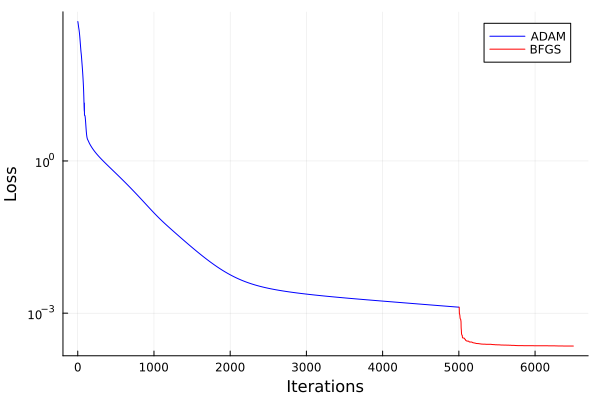

In [15]:
plot(1:5000, losses[1:5000], yaxis=:log10, xlabel="Iterations", ylabel="Loss", label="ADAM", color=:blue)
plot!(5001:length(losses), losses[5001:end], yaxis=:log10, label="BFGS", color=:red)

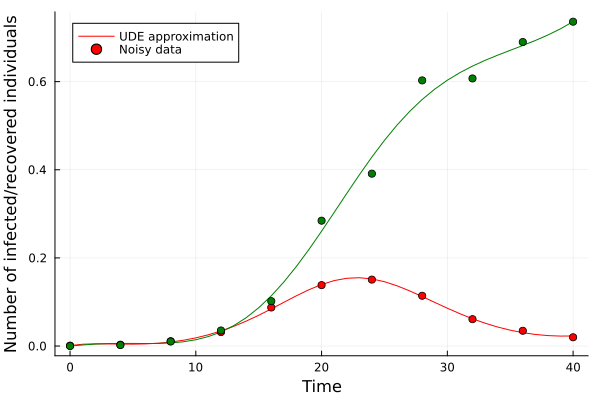

In [16]:
X̂ = predict(p_trained, t)
plot(t, X̂[2:3, :]', xlabel = "Time", ylabel = "Number of infected/recovered individuals", color = [:red :green], 
     label = ["UDE approximation" nothing])
scatter!(t[begin:4:end], X_noisy', color = [:red :green], label = ["Noisy data" nothing])

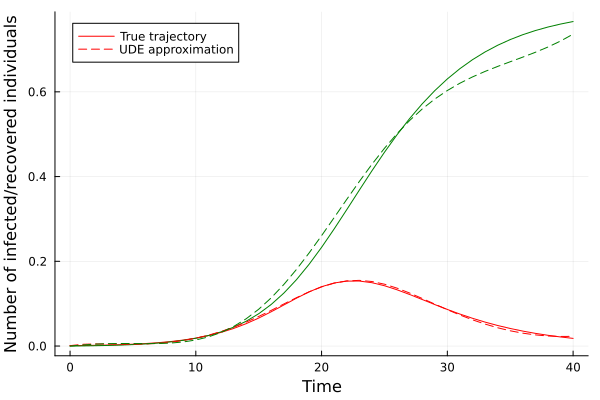

In [17]:
plot(t, X[2:3, :]', xlabel = "Time", ylabel = "Number of infected/recovered individuals", color = [:red :green], 
     label = ["True trajectory" nothing])
plot!(t, X̂[2:3, :]', color = [:red :green], linestyle = :dash, label = ["UDE approximation" nothing])

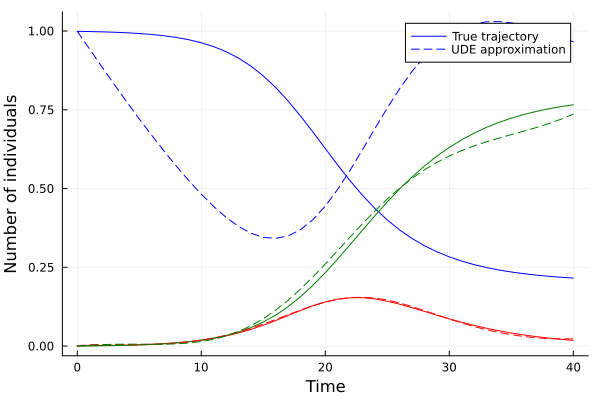

In [18]:
plot(t, X', xlabel = "Time", ylabel = "Number of individuals", color = [:blue :red :green], 
     label = ["True trajectory" nothing nothing])
plot!(t, X̂', color = [:blue :red :green], linestyle = :dash, label = ["UDE approximation" nothing nothing])

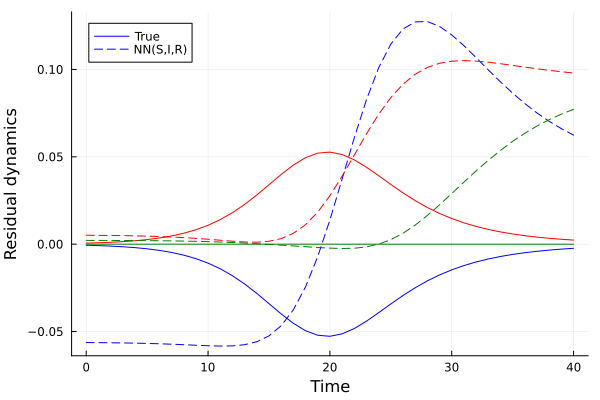

In [19]:
# True residual dynamics (i.e. interactions of predictors) along the true trajectory
dynamics_true = [-β/N * (X[1, :] .* X[2, :])'; β/N * (X[1, :] .* X[2, :])'; zeros(length(t))']
# Neural network guess along the true trajectory
dynamics_nn = Lux.apply(model, X, p_trained, st)[1]

plot(t, dynamics_true', xlabel = "Time", ylabel = "Residual dynamics", 
     color = [:blue :red :green], label = ["True" nothing nothing])
plot!(t, dynamics_nn', color = [:blue :red :green], linestyle = :dash, label = ["NN(S,I,R)" nothing nothing])

There is slight overfitting of the observed data. The unobserved state and the residual dynamics are not approximated. 